# Setup

https://github.com/facebookresearch/faiss/wiki/Getting-started

**We assume row-major storage, ie. the j'th component of vector number i is stored in row i, column j of the matrix. Faiss uses only 32-bit floating point matrices.**

In [1]:
import numpy as np
import faiss

# Test

In [2]:
d = 64                           # dimension
nb = 100000                      # database size
nq = 10000                       # nb of queries
np.random.seed(1234)             # make reproducible
xb = np.random.random((nb, d)).astype('float32')
xb[:, 0] += np.arange(nb) / 1000.
xq = np.random.random((nq, d)).astype('float32')
xq[:, 0] += np.arange(nq) / 1000.

In [3]:
xb.shape, xq.shape

((100000, 64), (10000, 64))

In [4]:
index = faiss.IndexFlatL2(d)   # build the index
print(index.is_trained)
index.add(xb)                  # add vectors to the index
print(index.ntotal)

True
100000


In [5]:
k = 4                          # we want to see 4 nearest neighbors
D, I = index.search(xb[:5], k) # sanity check
print(I)
print(D)
D, I = index.search(xq, k)     # actual search
print(I[:5])                   # neighbors of the 5 first queries
print(I[-5:])                  # neighbors of the 5 last queries

[[  0 393 363  78]
 [  1 555 277 364]
 [  2 304 101  13]
 [  3 173  18 182]
 [  4 288 370 531]]
[[0.        7.1751738 7.20763   7.2511625]
 [0.        6.3235645 6.684581  6.799946 ]
 [0.        5.7964087 6.391736  7.2815123]
 [0.        7.2779055 7.527987  7.6628466]
 [0.        6.7638035 7.2951202 7.3688145]]
[[ 381  207  210  477]
 [ 526  911  142   72]
 [ 838  527 1290  425]
 [ 196  184  164  359]
 [ 526  377  120  425]]
[[ 9900 10500  9309  9831]
 [11055 10895 10812 11321]
 [11353 11103 10164  9787]
 [10571 10664 10632  9638]
 [ 9628  9554 10036  9582]]


1.) https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index#will-you-perform-few-searches

In [ ]:
d = 512
index = faiss.IndexFlatIP(d)

2.) IndexFlatIP with normalized vector for cosine similarity (normalize vectors beforehand). https://github.com/facebookresearch/faiss/wiki/Faiss-indexes

https://github.com/facebookresearch/faiss/blob/master/gpu/test/test_pytorch_faiss.py

https://github.com/facebookresearch/faiss/wiki/Brute-force-search-without-an-index#brute-force-search-on-cpu

https://github.com/facebookresearch/faiss/wiki/Running-on-GPUs

# Setup

In [2]:
xb = np.load('pred/feats_train.npy')
yb = np.load('pred/targs_train.npy')
xq = np.load('pred/feats_valid.npy')
yq = np.load('pred/targs_valid.npy')

In [3]:
xb.shape # nb-by-d

(28480, 512)

In [4]:
xq.shape # nq-by-d (query vectors)

(7738, 512)

In [5]:
yb.shape, yq.shape

((28480,), (7738,))

In [6]:
## setup
d = xb.shape[1] # 512
nlist = int(4*np.sqrt(xb.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 675)

In [7]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [8]:
xb.max()

34.747166

In [9]:
faiss.normalize_L2(xb)

In [10]:
xb.max()

0.20313895

In [11]:
index.train(xb)

In [12]:
index.add_with_ids(xb, yb)

In [13]:
print(index.is_trained)
print(index.ntotal)

True
28480


## Train dataset

In [14]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(xb, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[ 880  880  880  880  880]
 [ 358 1025  358  358  589]
 [ 747  747  298  298  298]
 [ 723  723  723  723  723]
 [ 807  807  807  807  807]]
[[880]
 [358]
 [747]
 [723]
 [807]]
[[0.9999999  0.81978416 0.7964642  0.71875656 0.71451867]
 [0.99999994 0.7125491  0.70746976 0.6914145  0.6503389 ]
 [1.         0.729566   0.7190633  0.6984681  0.6754602 ]
 [1.0000001  0.8504113  0.8446528  0.8238198  0.81842124]
 [1.         0.8744553  0.86247766 0.8502133  0.8297723 ]]


In [15]:
yb.max(), I_train.max()

(1107, 1107)

### Train accuracy

In [16]:
I_train[:,0].shape, yb.shape

((28480,), (28480,))

In [17]:
# Accuracy
np.equal(I_train[:,0], yb).sum()/len(yb)

1.0

In [18]:
I_train[:10,0], yb[:10]

(array([880, 358, 747, 723, 807, 484, 279, 590, 246, 870]),
 array([880, 358, 747, 723, 807, 484, 279, 590, 246, 870]))

In [19]:
I_train[-10:,0], yb[-10:]

(array([957, 567, 592,  92, 641, 777, 760, 288, 355, 262]),
 array([957, 567, 592,  92, 641, 777, 760, 288, 355, 262]))

## Valid dataset

In [20]:
xq.max()

26.715216

In [21]:
faiss.normalize_L2(xq)

In [22]:
xq.max()

0.20355459

In [23]:
D_valid, I_valid = index.search(xq, k) # actual search

In [24]:
xq.shape, yq.shape

((7738, 512), (7738,))

In [25]:
I_valid.shape, D_valid.shape

((7738, 5), (7738, 5))

In [26]:
print(I_valid[:5]) # neighbors of the 5 first queries
print(yq[:5].reshape((5,1)))
print(D_valid[:5])

[[773 773 773 773 773]
 [581 581 581 581 581]
 [432 552 873   6 951]
 [842 842 842 842 842]
 [829 829 472 829 829]]
[[352]
 [361]
 [503]
 [505]
 [ 70]]
[[0.62117064 0.61026514 0.5783237  0.54274446 0.53929734]
 [0.58277637 0.55753195 0.5471376  0.52974564 0.5239972 ]
 [0.51995504 0.50595415 0.44293255 0.43805957 0.4254344 ]
 [0.6076556  0.590749   0.58873665 0.5834438  0.58302367]
 [0.5711089  0.53516287 0.52997565 0.5183896  0.4921634 ]]


In [27]:
print(I_valid[-5:]) # neighbors of the 5 last queries
print(yq[-5:].reshape((5,1)))
print(D_valid[-5:])

[[ 461  445  728  445  445]
 [ 503  503  503  503  503]
 [ 981  981  981  357  357]
 [ 715  937  715   23  459]
 [1062  399 1062 1062  399]]
[[103]
 [202]
 [824]
 [328]
 [509]]
[[0.5480005  0.51625204 0.4980685  0.45474982 0.44727704]
 [0.5883873  0.5339542  0.52783245 0.5191296  0.5158694 ]
 [0.4667648  0.4596996  0.4362784  0.4260381  0.4210328 ]
 [0.60262525 0.58653855 0.4269622  0.4253887  0.42438567]
 [0.48088986 0.4799772  0.47175464 0.46832532 0.45421815]]


In [30]:
np.save('pred/preds_valid.npy', I_valid)

### Valid accuracy

In [31]:
I_valid[:,0]

array([ 773,  581,  432, ...,  981,  715, 1062])

In [32]:
yq

array([352, 361, 503, ..., 824, 328, 509])

In [33]:
# Correct elements
np.equal(I_valid[:,0], yq).sum()

1506

In [34]:
# Accuracy
np.equal(I_valid[:,0], yq).sum()/len(yq)

0.19462393383303178

In [35]:
valid_correct = np.equal(I_valid[:,0], yq)

In [36]:
valid_correct

array([False, False, False, ..., False, False, False])

In [37]:
np.save('pred/preds_valid_correct.npy', valid_correct)

### Valid confusion matrix

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [39]:
cm = confusion_matrix(I_valid[:,0], yq)

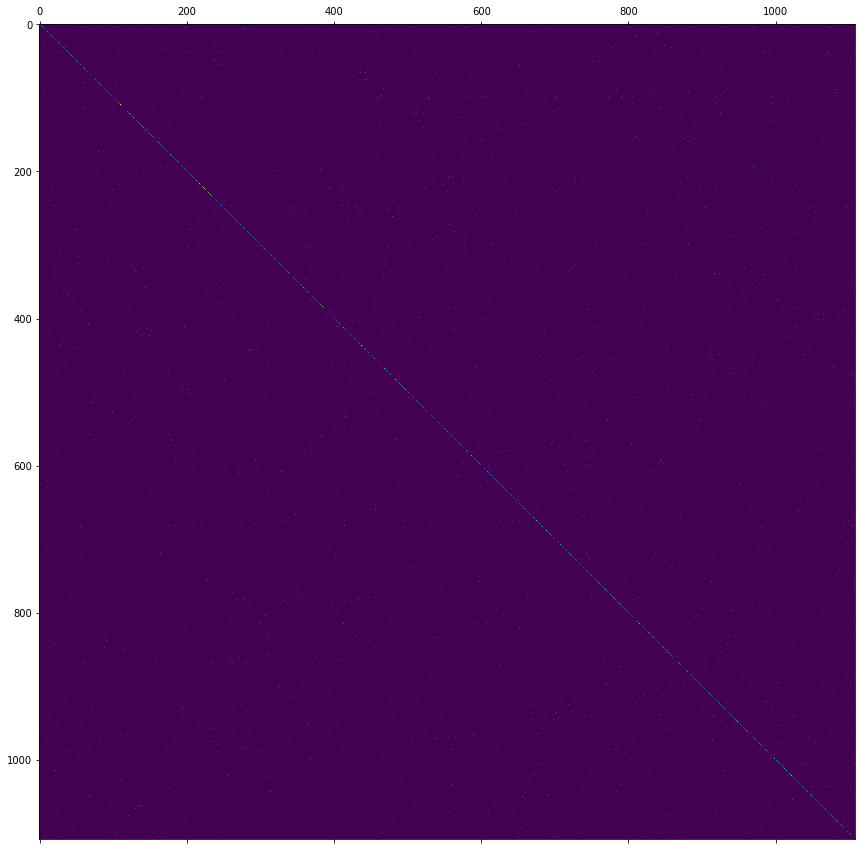

In [40]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm)

In [41]:
cm.shape

(1108, 1108)

In [42]:
np.eye(1108, dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [43]:
cm[np.eye(1108, dtype=bool)].sum()

1506

In [44]:
cm[~np.eye(1108, dtype=bool)].sum()

6232

In [45]:
cm[np.eye(1108, dtype=bool)].sum()/(cm[~np.eye(1108, dtype=bool)].sum() + cm[np.eye(1108, dtype=bool)].sum())

0.19462393383303178

In [46]:
~np.eye(1108, dtype=bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [47]:
cm[~np.eye(1108, dtype=bool)]

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
-(np.eye(1108)-1)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [49]:
cm * -(np.eye(1108)-1)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [50]:
cm_wodia = (cm * -(np.eye(1108)-1))

In [51]:
cm_wodia.shape

(1108, 1108)

In [52]:
cm_wodia.sum(axis=0)

array([3., 5., 4., ..., 7., 6., 5.])

In [53]:
cm_wodia.sum(axis=1)

array([ 9.,  6.,  1., ...,  3., 10.,  4.])

In [73]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, classes=np.unique(yq),
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, #classes=np.unique(yq), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Test dataset

In [54]:
xq_test = np.load('pred/feats_test.npy')

In [55]:
xq_test.max()

31.948633

In [56]:
faiss.normalize_L2(xq_test)

In [57]:
xq_test.max()

0.19971208

In [58]:
D_test, I_test = index.search(xq_test, k) # actual search

In [59]:
xq_test.shape, I_test.shape, D_test.shape

((19897, 512), (19897, 5), (19897, 5))

In [60]:
print(I_test[:5]) # neighbors of the 5 first queries
print(D_test[:5])

[[  18   18  594  328  944]
 [ 499  564  499  499  499]
 [ 525  383  382  382  382]
 [1043 1043 1043 1043 1043]
 [ 903  903  903  903  903]]
[[0.625869   0.5925888  0.5897664  0.5835905  0.5812212 ]
 [0.6195079  0.58843553 0.52641654 0.5078411  0.50139904]
 [0.562585   0.5283034  0.50461507 0.48061353 0.47412875]
 [0.58790773 0.5380561  0.5295799  0.5268737  0.51929104]
 [0.59249866 0.5446235  0.5385848  0.5050217  0.49314755]]


In [61]:
print(I_test[-5:]) # neighbors of the 5 last queries
print(D_test[-5:])

[[557 557 557 557 557]
 [316 316 316 316 316]
 [429 429 429 429 429]
 [271 271 271 271 271]
 [557 557 557 557 557]]
[[0.6806058  0.67799187 0.6715148  0.6584677  0.64852375]
 [0.7490498  0.7270405  0.71443546 0.7096423  0.702741  ]
 [0.6027899  0.5973835  0.56207025 0.55714154 0.55056155]
 [0.6715293  0.66902375 0.662141   0.66060334 0.657367  ]
 [0.75773305 0.7466129  0.7382209  0.7319839  0.72340125]]


In [62]:
I_test[2]

array([525, 383, 382, 382, 382])

In [63]:
np.unique(I_test[2], return_counts=True)

(array([382, 383, 525]), array([3, 1, 1]))

In [64]:
preds_test = I_test[:,0]

In [65]:
np.save('pred/preds_test.npy', preds_test)